# Purpose Statement:  

Waehle Industrygruppe aus im Rahmen der AllIndustrypdf Betrachtung um starke Industrien und ihre  
Memebe STocks einzel zu betrachten.  
Es werden sowohl Liniencharts mit der relativen Staerke  
zum SnP dargetllt als auch für jeden der Stocsk ein detailiertes Candöe Plot mi MACD und Volumen und MAs  
[Updated 08 Dez.2024]

In [16]:
# Run me !
import pandas as pd
import math
import numpy as np

import matplotlib as mpl
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from IPython.display import display, HTML
from datetime import datetime
# from datetime import date

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


from IPython.display import display, HTML


display(HTML("<style>.container { width:100% !important; }</style>"))

#import dataframe_image as dfi

from matplotlib.backends.backend_pdf import PdfPages
import finplot as fplt

import os
import sys
import csv
currentdir = os.path.abspath('')
parentdir = os.path.realpath(os.path.join(currentdir, '..'))
Classdir = os.path.realpath(os.path.join(parentdir, 'TC'))
sys.path.insert(0, parentdir)
sys.path.insert(0, Classdir)


#############################################################
#print(parentdir)
import signalgenerator as sg
import underly  as ul

from lib import FileStuff
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

plt.rcParams['axes.grid'] = True

css = """
.output {
    flex-direction: column;
}
"""
HTML('<style>{}</style>'.format(css))

# Choose the Parameters

startdate=widgets.Text(
    value='2024-08-01',
    placeholder='yyyy-mm-dd',
    description='Start of Analysis',
    disabled=False   
)


enddate=widgets.Text(
    value=str(datetime.today().strftime("%Y-%m-%d")),
    placeholder='yyyy-mm-dd',
    description='End of Analysis',
    disabled=False   
)



display(startdate)
display(enddate)

Text(value='2024-08-01', description='Start of Analysis', placeholder='yyyy-mm-dd')

Text(value='2025-01-17', description='End of Analysis', placeholder='yyyy-mm-dd')

In [9]:
# Plotting routine 
def plotte(sample,name):
    
    myrcparams={'axes.labelsize':'medium'}
    mystyle = mpf.make_mpf_style(base_mpf_style='sas',rc=myrcparams)
    
    ticks = sample.loc[(sample.index.day==3)].index
    ticklocations = [ sample.index.get_loc(t) for t in ticks]
    ticklabels = [ (tick.strftime('%d')[:3]) for tick in ticks ]
    
    # 50EMA unter Close
    wedgepop_cond=np.where((sample["EMA50"]<sample["Close"]),1,0) 
    # Close über max(EMA21,EMA10)
    wedgepop_cond2 =np.where(sample["Close"]> sample[["EMA21","EMA10"]].max(axis=1),1,0)  ## Mo = 0, Sunday = 6)
    # 1% Anstieg ggueber Vortag
    wedgepop_cond0 =np.where( (sample["Percent Change"]>0.01),1,0) 
    # Am Tag zuvor: Close < max(EMA10,EMA21)
    wedgepop_cond1 =np.where( (sample["Close"].shift(1)<sample[["EMA21","EMA10"]].shift(1).max(axis=1)),1,0)  ## Mo = 0, Sunday = 6)


    ## Summary:
    WP = wedgepop_cond2*wedgepop_cond0*wedgepop_cond1
    
    
    
    # EMA10 >  EMA21
    wedgepop_cond3a= np.where((sample["EMA10"]>=sample["EMA21"]),1,0) 
    # AN einem der drei nacheilenden  Tage EMA10 > EMA20
    wedgepop_cond3b= np.where( (sample["EMA21"].shift(-1)<sample["EMA10"].shift(-1)),1,0)
    wedgepop_cond3c= np.where( (sample["EMA21"].shift(-2)<sample["EMA10"].shift(-2)),1,0)
    wedgepop_cond3d= np.where( (sample["EMA21"].shift(-3)<sample["EMA10"].shift(-3)),1,0)
    ## ODER verknuepft
    wedgepop_cond3= wedgepop_cond3a\
                        +wedgepop_cond3b\
                        +wedgepop_cond3c\
                        +wedgepop_cond3d 
    
    
    # AN einem der drei voreilenden  Tage EMA10 < EMA20
    wedgepop_cond3b1= np.where( (sample["EMA21"].shift(1)>sample["EMA10"].shift(1)),1,0)
    wedgepop_cond3c1= np.where( (sample["EMA21"].shift(2)>sample["EMA10"].shift(2)),1,0)
    wedgepop_cond3d1= np.where( (sample["EMA21"].shift(3)>sample["EMA10"].shift(3)),1,0)
    ### ODER verknuepft
    wedgepop_cond31=\
                    wedgepop_cond3b1\
                    +wedgepop_cond3c1\
                    +wedgepop_cond3d1 
    
    #Innerhalb 3 Tagen danach: EMA21 < EMA10
    ##  Innerhalb 3 Tagen zuvor: EMA21 > EMA10 
    # Close über max(EMA21,EMA10)
    # +1% Close
    #EMA50<EMA21
    sample["wedgepop"]=WP\
                        #wedgepop_cond3\
                        #*wedgepop_cond31 \
                        #*wedgepop_cond2 \
                        #*wedgepop_cond0\
                        #*wedgepop_cond
    startdays=list(sample.loc[sample["wedgepop"]>0].index)
    
    
    p1=mpf.make_addplot(sample["EMA10"])
    p2=mpf.make_addplot(sample["EMA21"])
    p3=mpf.make_addplot(sample["EMA50"])
    p4=mpf.make_addplot(sample["MACD_week"])
    
    
    candle_data = mpf.make_addplot(sample[['Open', 'Close', 'High', 'Low',"Volume"]], type='candle')
    macdd = mpf.make_addplot(sample["MACDsign_week"], panel=2, color='g', title='MACD d')
    macdw = mpf.make_addplot(sample["MACD_week"], panel=2, color='r', title='MACD w')
    
    # Plot with additional panes
    #mpf.plot(df, type='candle', volume=True, addplot=[ap0, ap1], panel_ratios=(1, 1, 1, 0.5))
    
    plotsadded=[p1,p2,p3,macdd,macdw,candle_data]
    
    fig , axlist = mpf.plot(sample, type='candle', style=mystyle, addplot=plotsadded, panel_ratios=(1, 0.2, 0.4),volume=True,  xrotation = 65,title=name,figscale=2.0, \
                     figratio=(16, 10), vlines=dict(vlines=startdays, linewidths=4.4,alpha=0.2,colors="gray"), returnfig=True)
    
    axlist[-2].xaxis.set_ticks(ticklocations)
    axlist[-2].set_xticklabels(ticklabels)
    mpf.show()

In [17]:
def open_pdf(file_path):
    if os.path.exists(file_path):
        try:
            webbrowser.open(file_path)
        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print("File does not exist")


def write_strings_to_csv(strings, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_NONE, escapechar='\\')
        writer.writerow(strings)
                    

In [18]:
universe2="US_long"
#universe2="Deutschland500"

startdatum =startdate.value
enddatum=enddate.value
#Produce
the_portfolio=sg.portfolio(universe2)

Sectors = pd.read_csv(parentdir+"\\ETFS\\Mutterlisten\\DataBase\\US_long_database.csv", sep=";", encoding='latin-1').Sector.to_list()
#Industries = pd.read_csv(parentdir+"\\ETFS\\Mutterlisten\\DataBase\\Deutschland500_database.csv", sep=";", encoding='latin-1').industry.to_list()
Industries = pd.read_csv(parentdir+"\\ETFS\\Mutterlisten\\DataBase\\US_long_database.csv", sep=";", encoding='latin-1').Industry.to_list()
Sectors=np.unique(Sectors)
Industries=np.unique(Industries)
# produce
universe="styles"
spy = sg.portfolio(universe,["SPY","RSP"])
spy.assets[0].read_grabbed_data()
spy.assets[1].read_grabbed_data()

spy_close = spy.matrix_of_grabbed_data("Close").truncate(before=startdatum, after = enddatum)

spy_factor=(spy_close.pct_change()+1).cumprod()-1

startstep=20
spy_factor.plot()

# SELECT Industry Group

In [19]:
# Choose the Parameters

Indus=widgets.Select(
    options=Industries,
    value=Industries[len(Industries)-1],
    rows=10,
    description='Industry:',
    disabled=False
)

Sect=widgets.Select(
    options=Sectors,
    value=Sectors[5],
    rows=10,
    description='Sector:',
    disabled=False
)o



tk=widgets.Text(
    value='nan',
    placeholder='Type IN tICKER sYMBOL',
    description='TICKER:',
    disabled=False   
)

display(Indus,tk)

Select(description='Industry:', index=150, options=(' Medicinal Chemicals and Botanical Products ', 'Accident …

Text(value='nan', description='TICKER:', placeholder='Type IN tICKER sYMBOL')

## Plot a single TICKER AND ITS INDUSTRY or A INDUSTRY WITHOUT SPECIFIC TICKER

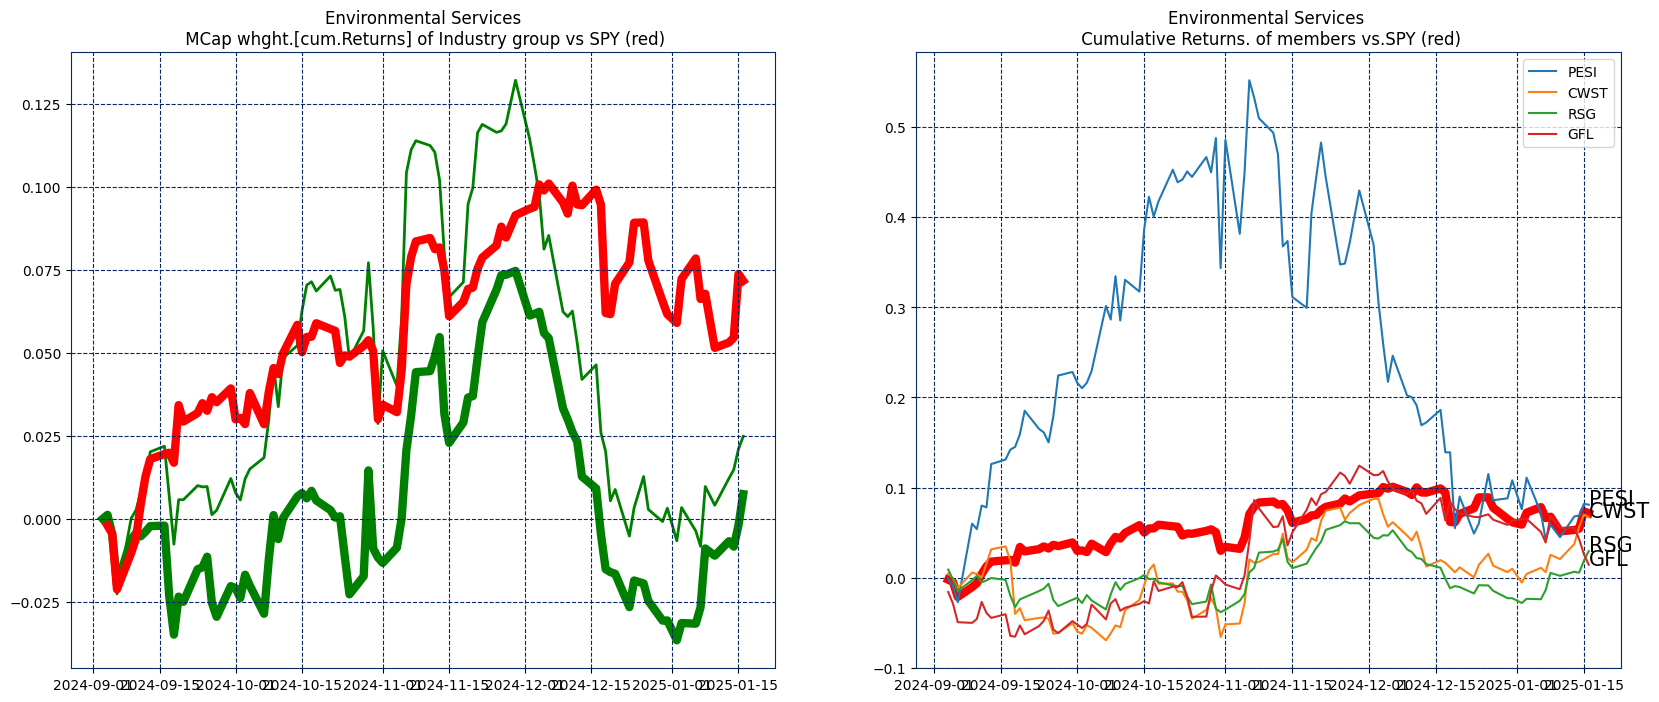

In [42]:
# Plot a specific Industry in Detail, so 4 Stocks per frame
###########################################################
###########################################################


### Portfolio fuer eine INdustry:
#IndusName = Indus.value
#SecName = Sect.value
indus = Indus.value
tkr=tk.value
sect = Sect.value
IndustrieOfInterest = Industries     

if indus!="nan" or tkr!="nan":
####  Neihter single Stock nor Industry selected to look at
###########################################################
    if indus !="nan":
        indus = indus
        tkr="nan"
    else:
        indus=the_portfolio.statics.loc[tkr]["industry"] 
    ## HIer entweder eine 
    liste_indus_stocks= the_portfolio.statics.loc[the_portfolio.statics["industry"]==indus].ticker.to_list()
    #liste_indus_stocks=["ASPN","BCC","BECN","BLDR","BZH","CCS","CODI","CSWI","CVCO","DFH","DHI","ETD","FAST","FND","FUL","GEO","GMS","GRBK","HBB","HD","HELE","HOV","IBP","IRS","JOE","KBH","LEG","LEGH","LEN","LGIH","LOW","LSEA","LZB","MBC","MHK","MHO","MTH","NVR","PHM","SHW","SKY","SNBR","STRS","THO","TILE","TMHC","TOL","TPH","TPX","TSCO","TTSH","UHG","WGO","WSM"]    
    
    if len(liste_indus_stocks)>0:
                NumOf4Packs=int(len(liste_indus_stocks)/4)+1
                #Build the portfolio of tickers:
                industry_portfolio = sg.portfolio(universe2,liste_indus_stocks)
                for asset  in industry_portfolio.assets:
                    asset.read_grabbed_data()

                ### PLotte Industry vs. SPY

                sup_portfs=[industry_portfolio,]

                industry_marketCap=industry_portfolio.statics["marketCap"].sum()

                #fig, ax = plt.subplots(ncols=2,sharex="col",figsize=(20,8))
                z=0
                s=0

                tradingviewchain=""

                for singel_pf in sup_portfs:
                    #((matrix[lower:upper]+1).cumprod()[-1:])-1

                    matrix_close= singel_pf.matrix_of_grabbed_data("Close").truncate(before=startdatum)
                    ### cum ulative returns
                    matrix_factor=(matrix_close.pct_change()+1).cumprod()-1
                    ### Sortiere 


                    # bilde EQUAL wheighted mean cum return of the industry 
                    matrix_factor_EQUAL_wheighted=pd.DataFrame()
                    matrix_factor_EQUAL_wheighted["Average"]=matrix_factor.sum(axis=1)/len(matrix_factor.columns)


                    # bilde MC wheighted mean cum return of the industry 
                    matrix_factor_marketcap_wheighted=matrix_factor.mul(industry_portfolio.statics["marketCap"],axis=1)
                    matrix_factor_marketcap_wheighted=matrix_factor_marketcap_wheighted/industry_marketCap
                    matrix_factor_marketcap_wheighted["Average"]=matrix_factor_marketcap_wheighted.sum(axis=1)


                    matrix_factor=matrix_factor.sort_values(matrix_factor.last_valid_index(), axis=1,ascending = False)

                    names = matrix_factor.columns.to_list()
                    x=[matrix_factor.index[-1] for c in names]
                    y=[matrix_factor[c].iloc[-1] for c in names]


                    
                    ############################################################
                    ## plot to right the cumulative returns of individual stocks  (factor)
                    for j in range(0,NumOf4Packs-1):
                        fig, ax = plt.subplots(ncols=2,sharex="col",figsize=(20,8))

                        z=0
                        s=0
                        ax[s+1].plot(matrix_factor[names[4*j:(j+1)*4]]) 
                        for k in range(4*j,min((j+1)*4,len(liste_indus_stocks))):  
                            ax[s+1].text(x[k],y[k],names[k],fontsize=15)
                    ## Add SPY Plot
                        #ax4=ax[s+1].twinx()
                        ax[s+1].plot(spy_factor["SPY"],color="red",zorder=1,linewidth=6)      
                        ax[s+1].legend(names[4*j:(j+1)*4])
                        
                        
                        #tradingviewchain=tradingviewchain+names[4*j]+","+names[4*j+1]+","+names[4*j+2]+","+names[4*j+3]+","+names[4*j+4]+","
                        
                        ax[s].plot(matrix_factor_marketcap_wheighted["Average"],color="green",zorder=1,linewidth=6)  
                        ax[s].plot(matrix_factor_EQUAL_wheighted["Average"],color="green",zorder=1,linewidth=2)  
                        ax[s].plot(spy_factor["SPY"],color="red",zorder=1,linewidth=6)      

                        ### Titles
                        ax[s].set_title(indus +"\n MCap whght.[cum.Returns] of Industry group vs SPY (red)")
                        ax[s+1].set_title(indus +" \n Cumulative Returns. of members vs.SPY (red)")
                        if tkr!="nan":
                            ax[s+1].plot(matrix_factor[tkr],color="blue",linewidth=6)
                            ax[s].plot(matrix_factor[tkr],color="blue",linewidth=3)


    # pdf_path = indus+".pdf"
    # with PdfPages(pdf_path) as pdf:
    #     for fig in plt.get_fignums():
    #         pdf.savefig(fig)  

    filename = parentdir+"\\TDVListen\\"+"wkly_"+indus[:3]+".txt"
    write_strings_to_csv(names, filename)
    
    pdf_path = parentdir+"\\TDVListen\\"+"SingleIndustry.pdf"
    with PdfPages(pdf_path) as pdf:
        for fig in plt.get_fignums():
            pdf.savefig(fig)




else:
    print("No single Indus output")


## Candle Analysis 

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


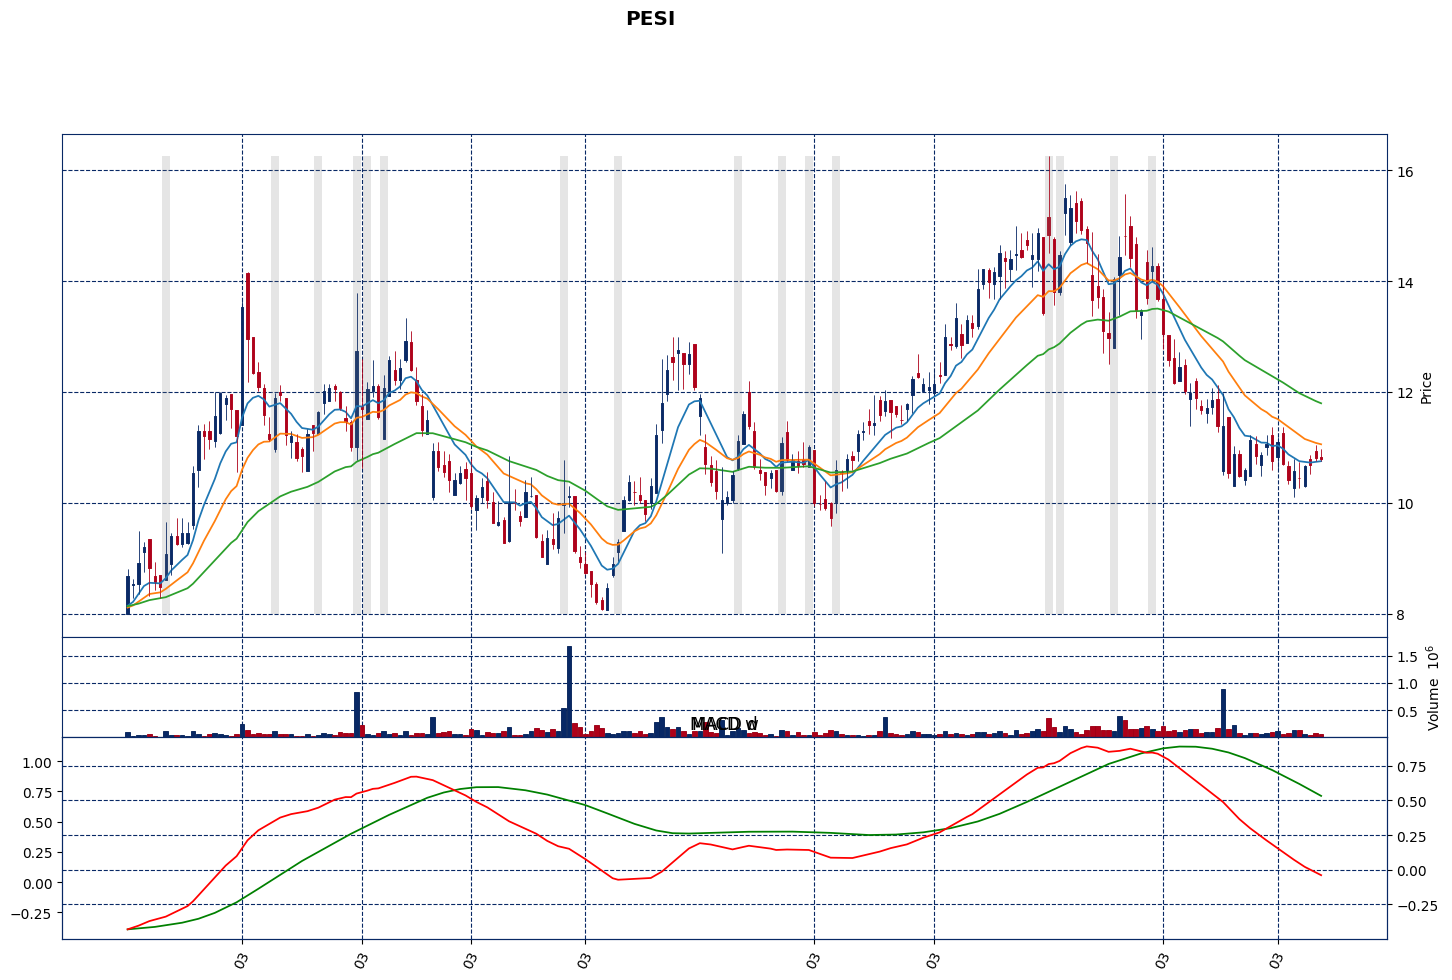

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


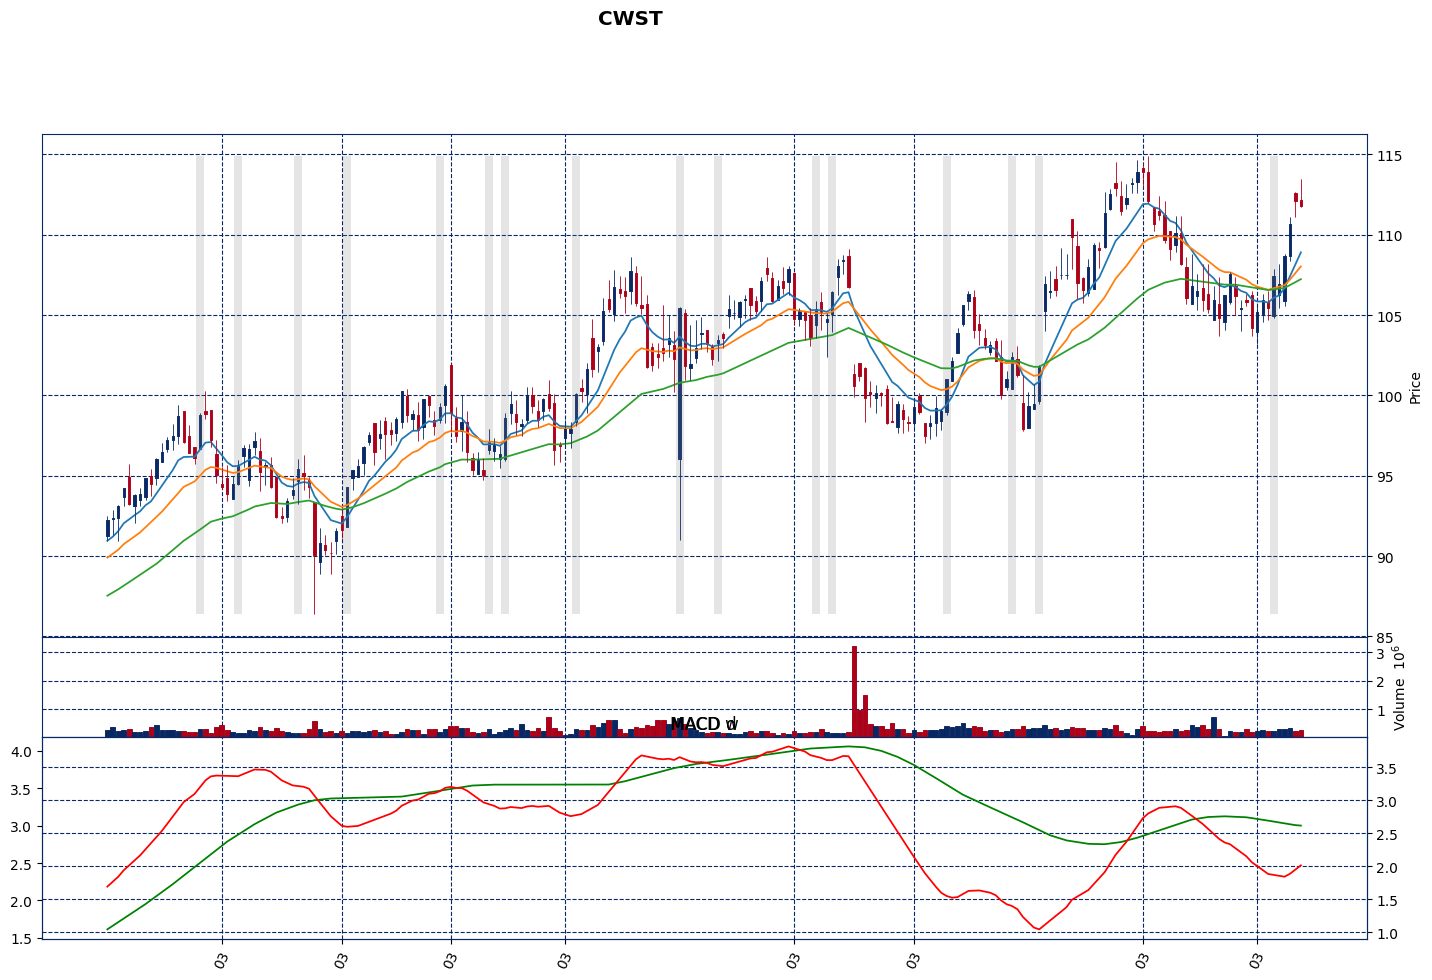

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


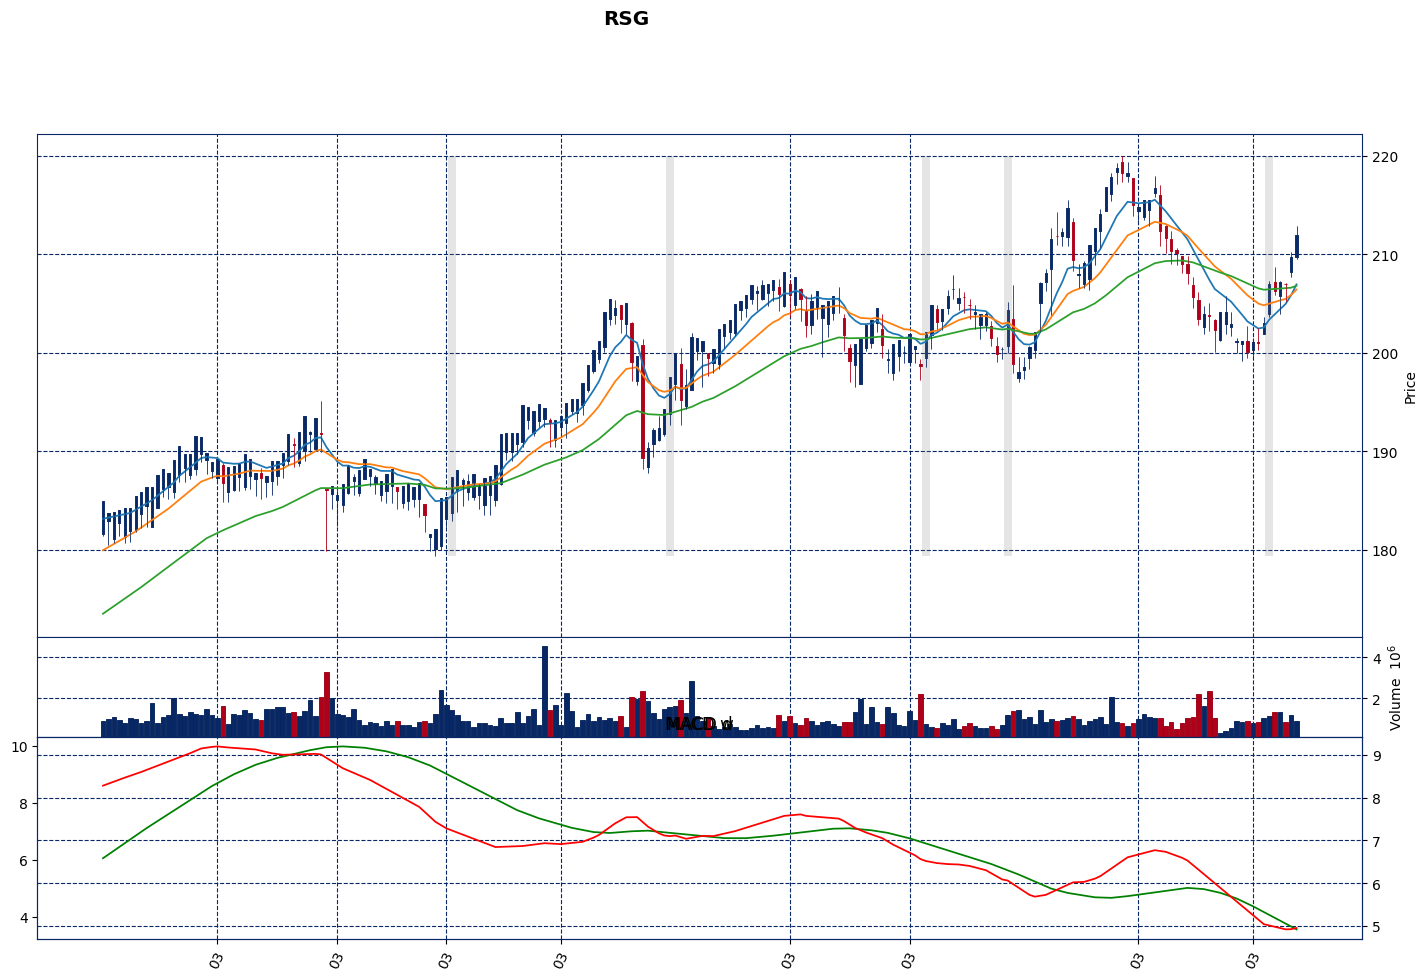

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


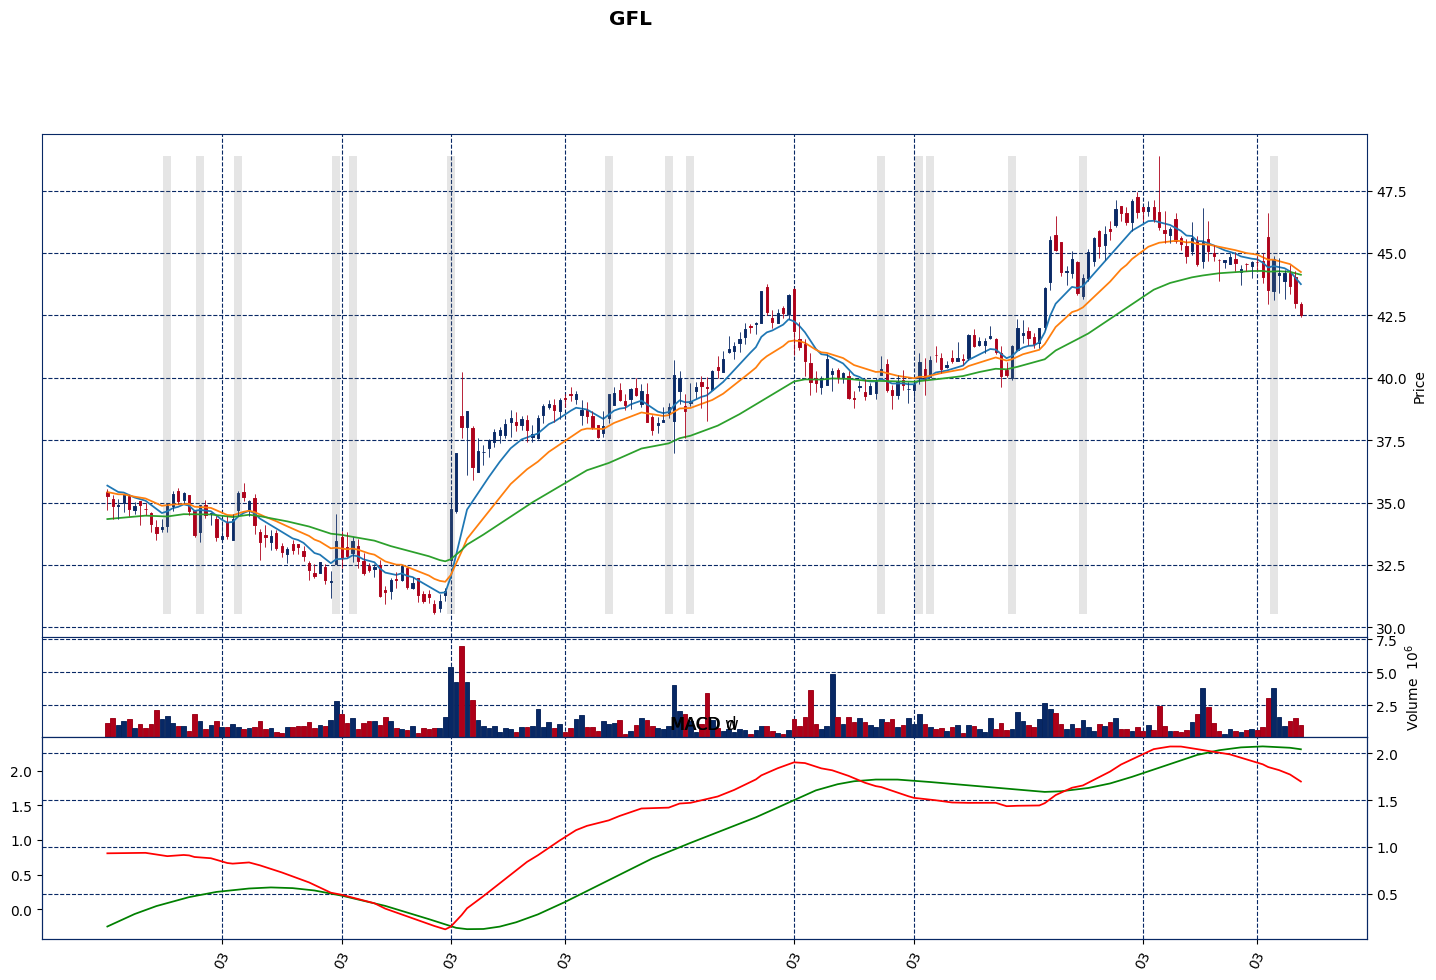

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


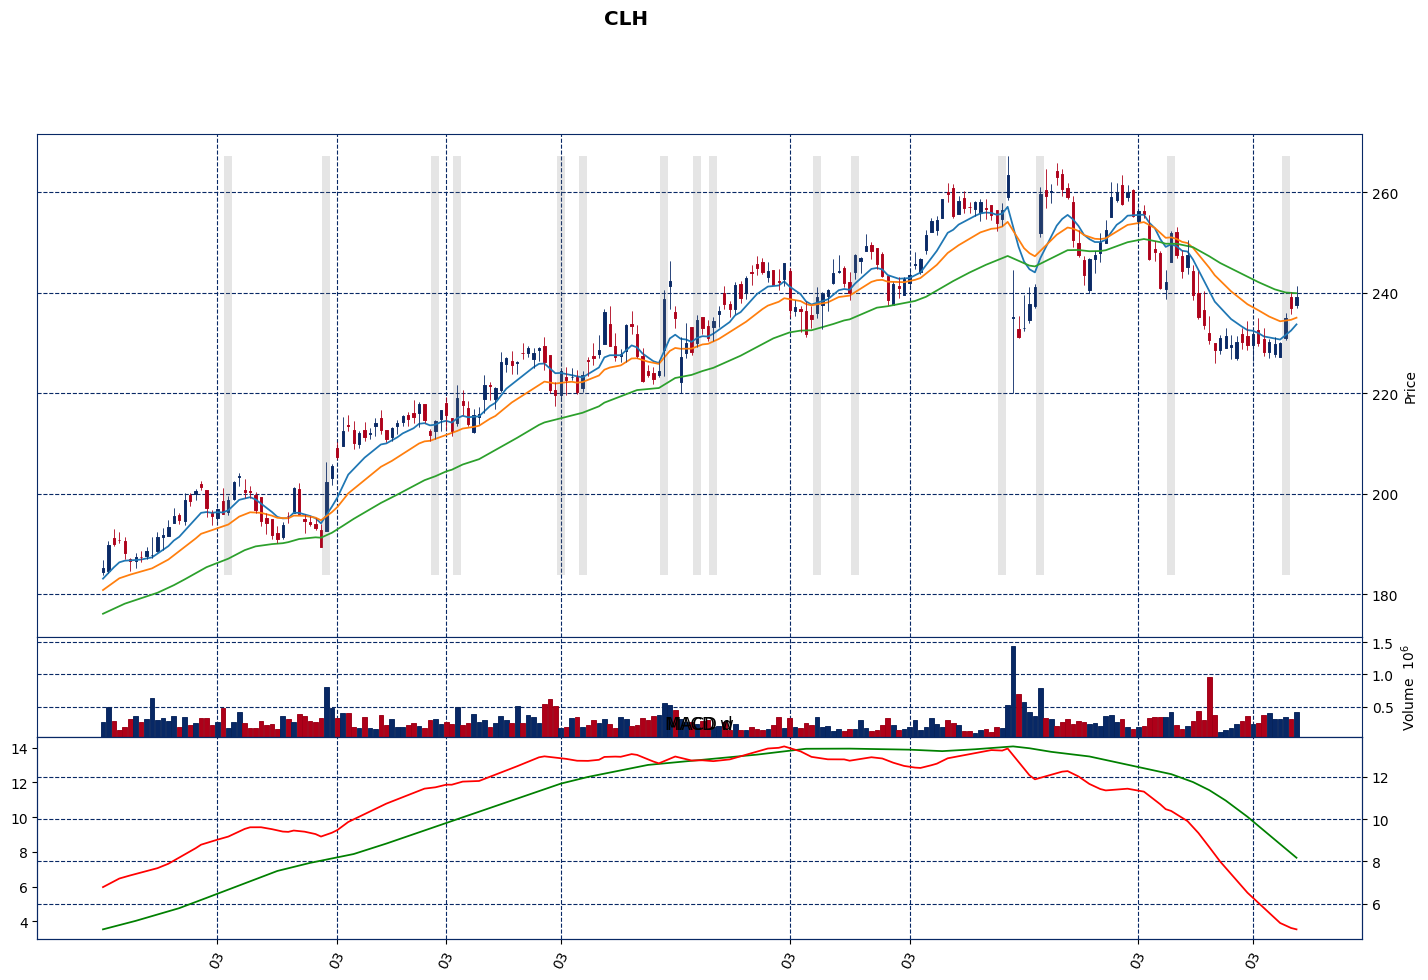

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


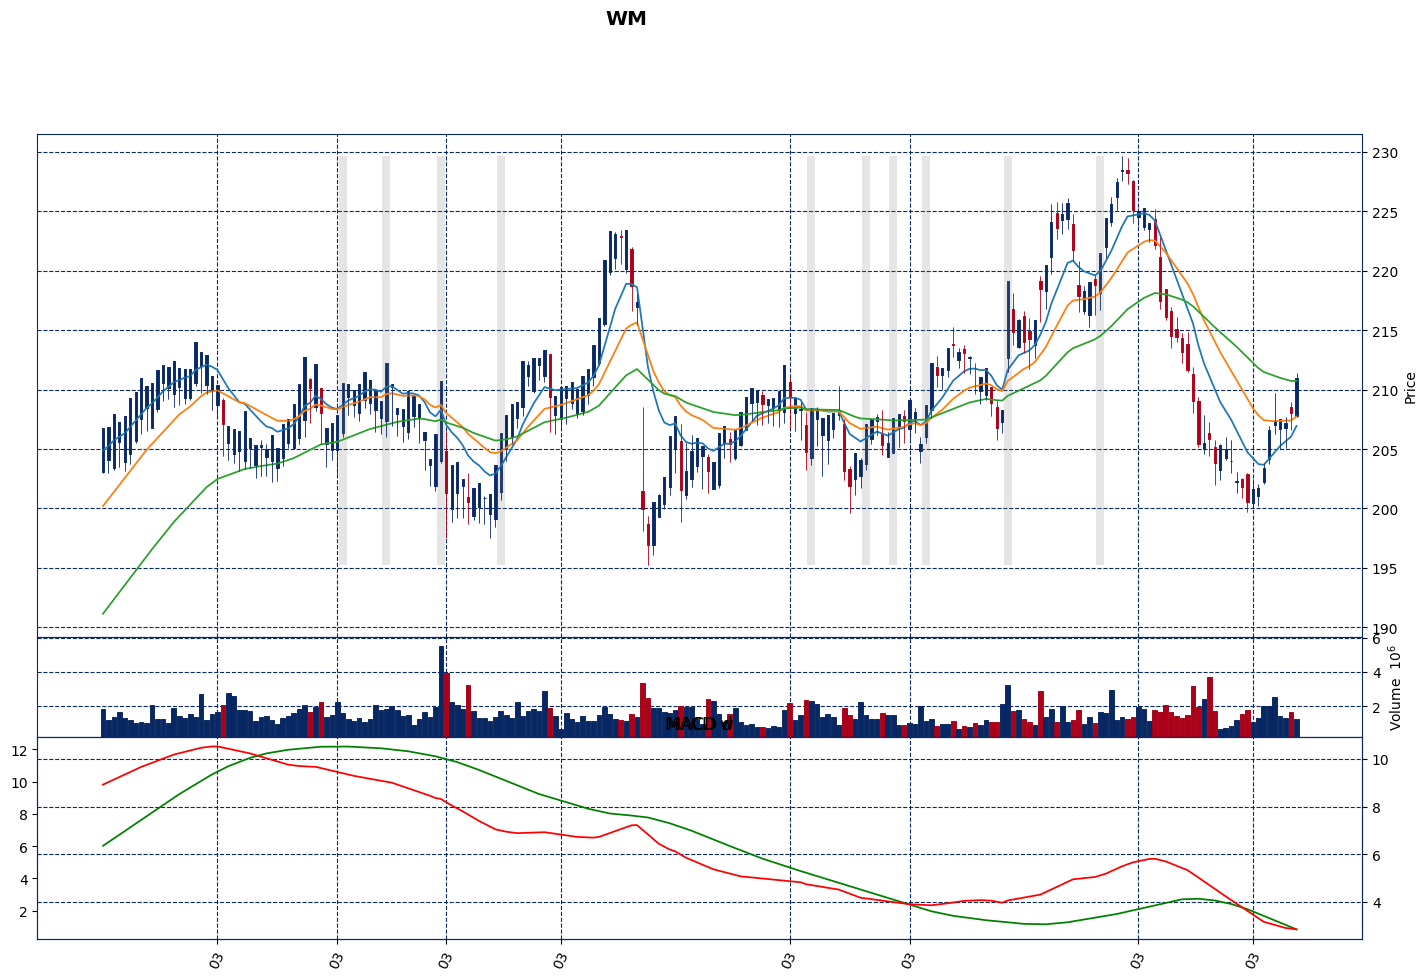

C:\Users\r889990\AppData\Local\Temp\1\ipykernel_10220\1901284738.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["wedgepop"]=WP\


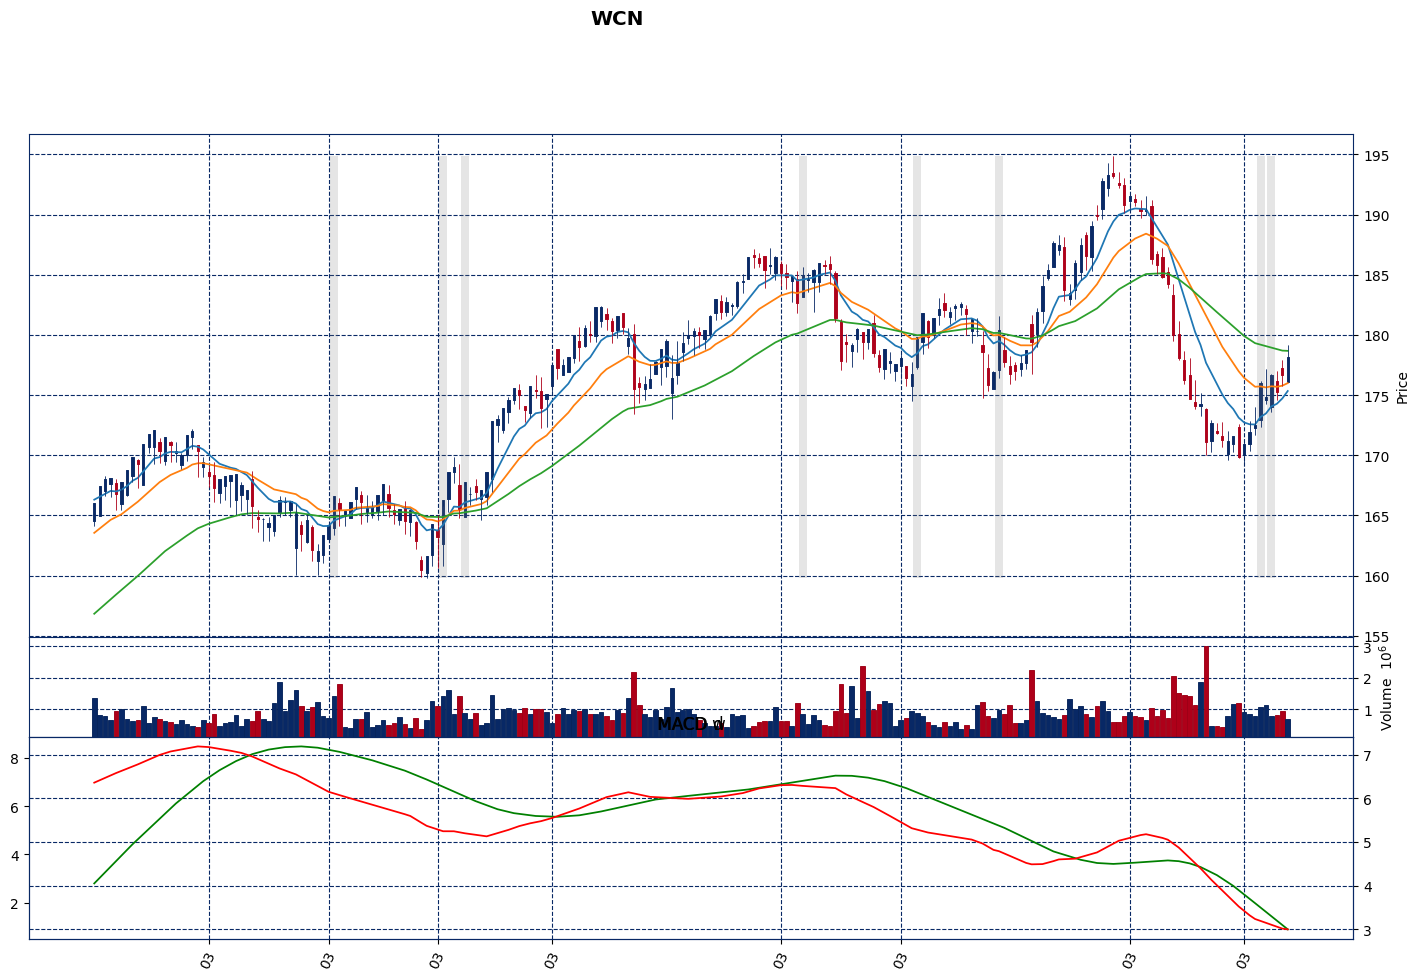

In [43]:
for name in names:
    assets = [a for a in industry_portfolio.assets if a.ticker==name]
    for asset in assets:
        sampl=asset.grabbed_data
        # data["EMA50"]=data["Factor"].ewm(span=50,adjust=False).mean()
        sampl["EMA10"]=sampl["Close"].ewm(span=10,adjust=False).mean()
        sampl["EMA21"]=sampl["Close"].ewm(span=21,adjust=False).mean()
        sampl["EMA50"]=sampl["Close"].ewm(span=50,adjust=False).mean()
    
        sample = sampl[-220:]
    
        plotte(sample,asset.ticker)

In [44]:
result

NameError: name 'result' is not defined